In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from backtesting import Backtest
from src.strategies import MomentumTimeSeries, SmaCross


url = "http://hilpisch.com/pyalgo_eikon_eod_data.csv"
raw = pd.read_csv(url, index_col=0, parse_dates=True).dropna()

/Users/ivankyulev/Projects/Notebooks/.venv/lib/python3.11/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [3]:
data = pd.DataFrame(raw['GDX'])

In [4]:
# Date,Open,High,Low,Close
data.rename(columns={'GDX': 'Open'}, inplace=True)
data['High'] = data['Open']
data['Low'] = data['Open']
data['Close'] = data['Open']
data['Returns'] = np.log(data['Close'] / data['Close'].shift(1))

SMA = 25
data['SMA'] = data['Close'].rolling(SMA).mean()
threshold = 3.5
data['Distance'] = data['Close'] - data['SMA']

data

,Open,High,Low,Close,Returns,SMA,Distance
Date,,,,,,,
2010-01-04,47.71,47.71,47.71,47.71,NaN,NaN,NaN
2010-01-05,48.17,48.17,48.17,48.17,0.009595,NaN,NaN
2010-01-06,49.34,49.34,49.34,49.34,0.023999,NaN,NaN
2010-01-07,49.10,49.10,49.10,49.10,-0.004876,NaN,NaN
2010-01-08,49.84,49.84,49.84,49.84,0.014959,NaN,NaN
...,...,...,...,...,...,...,...
2019-12-24,28.66,28.66,28.66,28.66,0.031546,27.2824,1.3776
2019-12-26,29.08,29.08,29.08,29.08,0.014548,27.3564,1.7236
2019-12-27,28.87,28.87,28.87,28.87,-0.007248,27.4176,1.4524


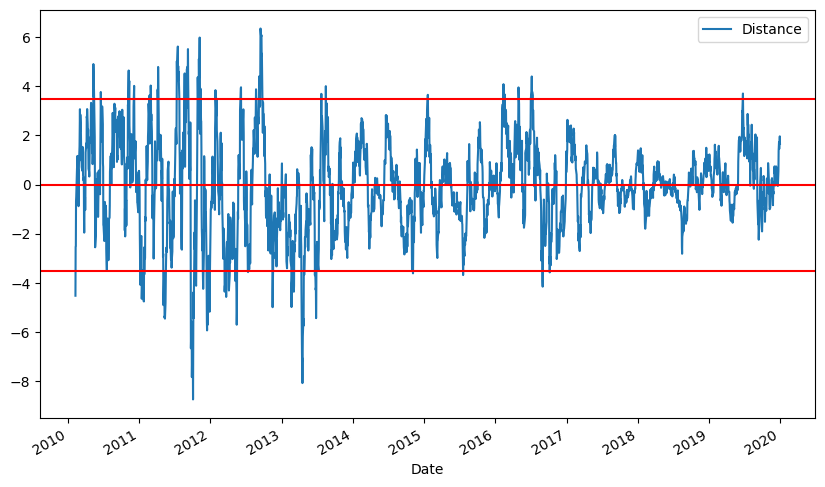

In [6]:
data['Distance'].dropna().plot(figsize=(10, 6), legend=True)
plt.axhline(threshold, color='r')
plt.axhline(-threshold, color='r')
plt.axhline(0, color='r')

<Axes: xlabel='Date'>

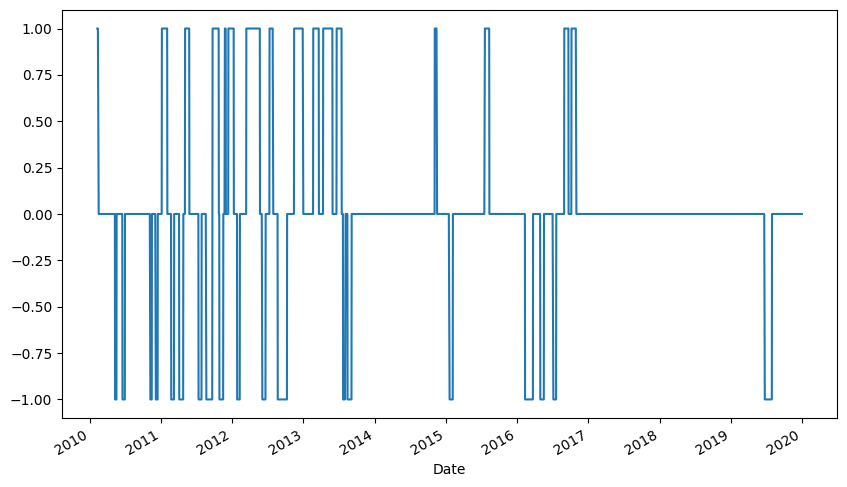

In [7]:
data['Position'] = np.where(data['Distance'] > +threshold, -1, np.nan)
data['Position'] = np.where(data['Distance'] < -threshold, 1, data['Position'])
data['Position'] = np.where(data['Distance'] * data['Distance'].shift(1) < 0, 0, data['Position'])
data['Position'] = data['Position'].ffill().fillna(0)
data['Position'].iloc[SMA:].plot(ylim=[-1.1, 1.1], figsize=(10, 6))

<Axes: xlabel='Date'>

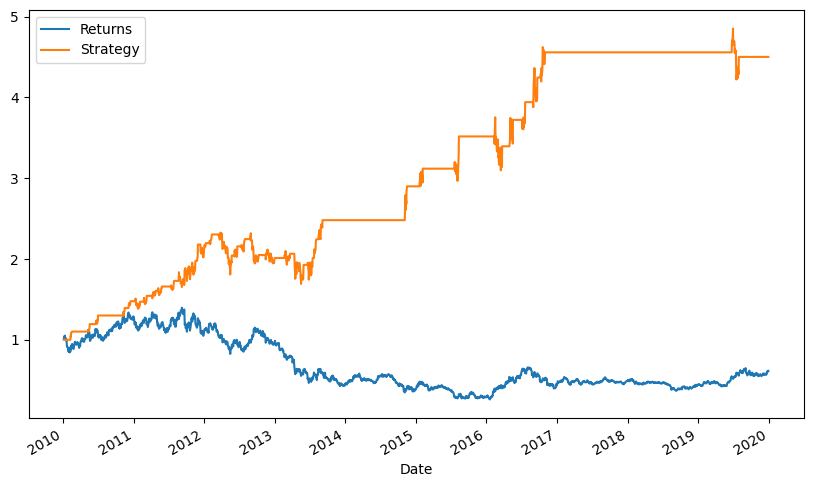

In [8]:
data['Strategy'] = data['Position'].shift(1) * data['Returns']
data[['Returns', 'Strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10, 6))

In [9]:
data['Strategy'].dropna().cumsum().apply(np.exp)

Date
2010-01-05    1.000000
2010-01-06    1.000000
2010-01-07    1.000000
2010-01-08    1.000000
2010-01-11    1.000000
                ...   
2019-12-24    4.501657
2019-12-26    4.501657
2019-12-27    4.501657
2019-12-30    4.501657
2019-12-31    4.501657
Name: Strategy, Length: 2515, dtype: float64

In [10]:
data

,Open,High,Low,Close,Returns,SMA,Distance,Position,Strategy
Date,,,,,,,,,
2010-01-04,47.71,47.71,47.71,47.71,NaN,NaN,NaN,0.0,NaN
2010-01-05,48.17,48.17,48.17,48.17,0.009595,NaN,NaN,0.0,0.0
2010-01-06,49.34,49.34,49.34,49.34,0.023999,NaN,NaN,0.0,0.0
2010-01-07,49.10,49.10,49.10,49.10,-0.004876,NaN,NaN,0.0,-0.0
2010-01-08,49.84,49.84,49.84,49.84,0.014959,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2019-12-24,28.66,28.66,28.66,28.66,0.031546,27.2824,1.3776,0.0,0.0
2019-12-26,29.08,29.08,29.08,29.08,0.014548,27.3564,1.7236,0.0,0.0
2019-12-27,28.87,28.87,28.87,28.87,-0.007248,27.4176,1.4524,0.0,-0.0


In [82]:
from backtesting import Backtest
from backtesting import Strategy
from src.strategies import MomentumTimeSeries, SmaCross
from src.indicators import simple_moving_average, daily_log_returns, substract_values, multiply_values


class MeanReversion(Strategy):
    n = 25
    threshold = 3.5

    def init(self):
        # Precompute the two moving averages
        self.returns = self.I(daily_log_returns, self.data.Close)
        self.sma = self.I(simple_moving_average, self.data.Close, self.n)
        self.distance = self.I(substract_values, self.data.Close, self.sma)
        self.distance_change = self.I(multiply_values, self.distance, np.roll(self.distance, 1))

    def next(self):
        if self.distance < -self.threshold:
            self.position.close()
            self.buy()

        elif self.distance > self.threshold:
            self.position.close()
            self.sell()

        if self.distance_change < 0:
            self.position.close()


bt = Backtest(data, MeanReversion, cash=10_000, commission=0, trade_on_close=True)
stats = bt.run()
stats


Start                     2010-01-04 00:00:00
End                       2019-12-31 00:00:00
Duration                   3648 days 00:00:00
Exposure Time [%]                   24.046105
Equity Final [$]                    34880.605
Equity Peak [$]                     37470.685
Return [%]                          248.80605
Buy & Hold Return [%]              -38.629218
Return (Ann.) [%]                   13.329941
Volatility (Ann.) [%]               21.908006
Sharpe Ratio                         0.608451
Sortino Ratio                        1.111272
Calmar Ratio                         0.472643
Max. Drawdown [%]                  -28.203002
Avg. Drawdown [%]                   -5.376461
Max. Drawdown Duration      979 days 00:00:00
Avg. Drawdown Duration       65 days 00:00:00
# Trades                                  151
Win Rate [%]                        48.344371
Best Trade [%]                      16.877637
Worst Trade [%]                     -9.931719
Avg. Trade [%]                    